In [1]:
############# WORK IN PROGRESS #################
# goal is to use several K optimization methods 
# to determine K for our stat arb class
# look in each cluster and selct a pair 

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from collections import Counter
from collections import OrderedDict
import requests
import json

import seaborn as sns
from statsmodels.tsa.api import adfuller
import yahoo_finance as yf
import pandas_datareader as pdr

In [3]:
# Modify some settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

In [4]:
random_state = 42

data = pd.read_csv('~/k_means/Data/sp_financials.csv')
data = data.drop(['SEC_Filings', 'Sector', 'Name'], axis=1)
symbol = data['Symbol']
data = data.set_index('Symbol')
data = data.fillna(0)
cols = ['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']
data = data[['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']]
data.head()

,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book
Symbol,,,,,,,,,,
MMM,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34
AOS,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35
ABT,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19
ABBV,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14
ACN,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62


In [5]:
# standardize data to have mean ~0 and var of 1
data_std = StandardScaler().fit_transform(data)

# save for later in df form
ds = pd.DataFrame(data_std, columns=cols)
ds = ds.set_index(symbol)

In [6]:
# PCA instance
variance = 0.98
pca = PCA(variance, n_components = 10)
principalComponents = pca.fit_transform(data_std)
PCA_components = pd.DataFrame(principalComponents)
PCA_components = PCA_components.set_index(symbol)

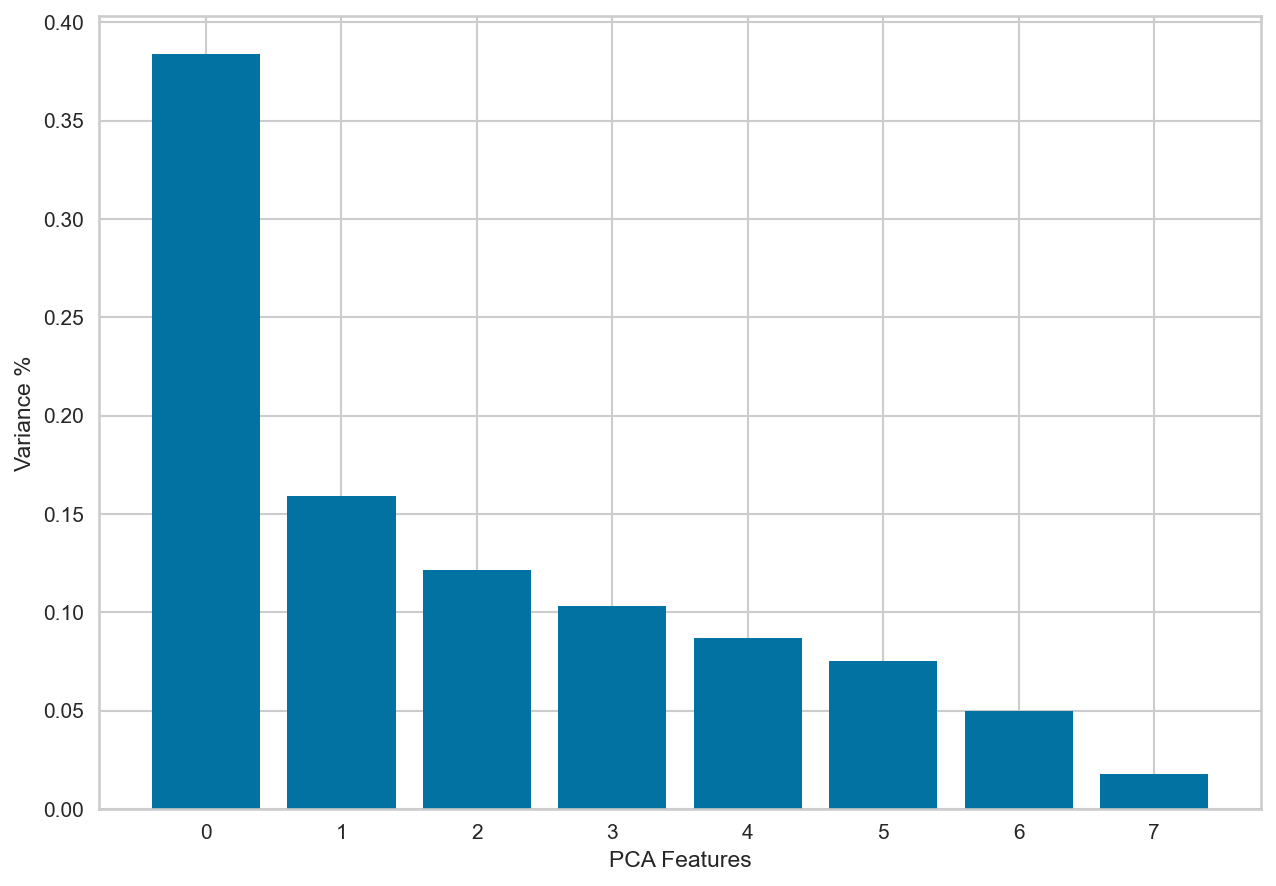

In [7]:
# plot variances
feat = range(pca.n_components_)
plt.bar(feat, pca.explained_variance_ratio_)
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.xticks(feat)
plt.show()

In [8]:
'''
# Elbow Method to find K
# Here we want to find within-cluster sum of squares as a function of the number of clusters 
# we want to choose the number of clusters so that adding another doesnt cause a significant
# improvement to the total within-cluster sum of squares
# inertia_ attribute can show this

def elbow(features, range_max):
    distortions = []
    K = range(1,range_max)
    for k in K:
        model = KMeans(n_clusters=k)
        model.fit_predict(features)
        distortions.append(model.inertia_)
        
    return K, distortions

k, d = elbow(data_std, 150)

plt.plot(k, d, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.show()

from sklearn.metrics import silhouette_score
sil = []
for i in range(2, 150):
    kmeans = KMeans(n_clusters = i).fit(principalComponents)
    lab = kmeans.labels_
    sil.append(silhouette_score(principalComponents, lab, metric='euclidean'))
    
plt.plot(sil)
plt.show()
'''

"\n# Elbow Method to find K\n# Here we want to find within-cluster sum of squares as a function of the number of clusters \n# we want to choose the number of clusters so that adding another doesnt cause a significant\n# improvement to the total within-cluster sum of squares\n# inertia_ attribute can show this\n\ndef elbow(features, range_max):\n    distortions = []\n    K = range(1,range_max)\n    for k in K:\n        model = KMeans(n_clusters=k)\n        model.fit_predict(features)\n        distortions.append(model.inertia_)\n        \n    return K, distortions\n\nk, d = elbow(data_std, 150)\n\nplt.plot(k, d, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Distortions')\nplt.show()\n\nfrom sklearn.metrics import silhouette_score\nsil = []\nfor i in range(2, 150):\n    kmeans = KMeans(n_clusters = i).fit(principalComponents)\n    lab = kmeans.labels_\n    sil.append(silhouette_score(principalComponents, lab, metric='euclidean'))\n    \nplt.plot(sil)\nplt.show()\n"

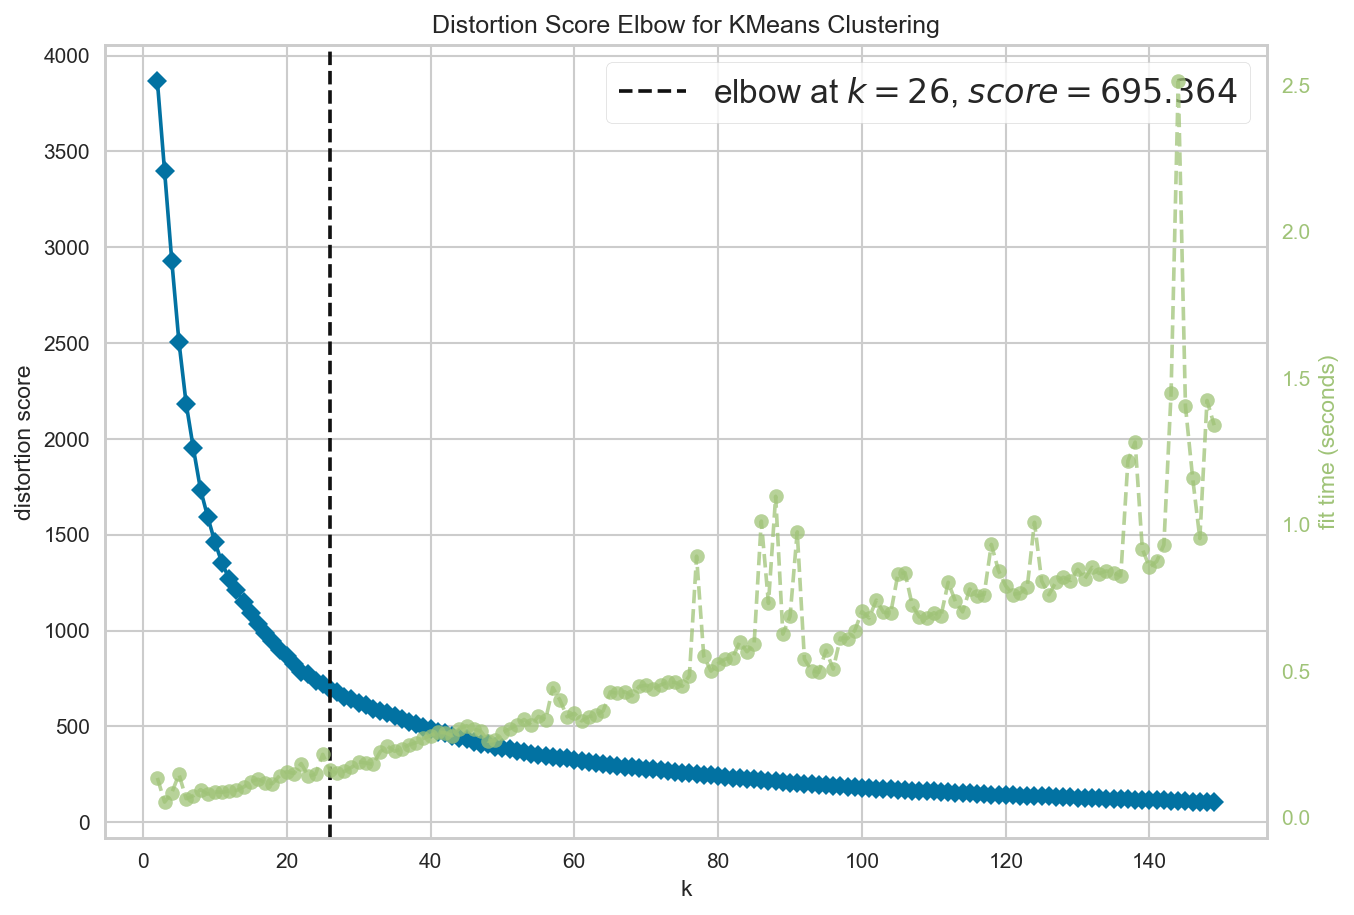

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
# different visualization
model = KMeans(init='k-means++', random_state=random_state)
visualizer = KElbowVisualizer(model, k=(2,150))
visualizer.fit(principalComponents)
visualizer.show()

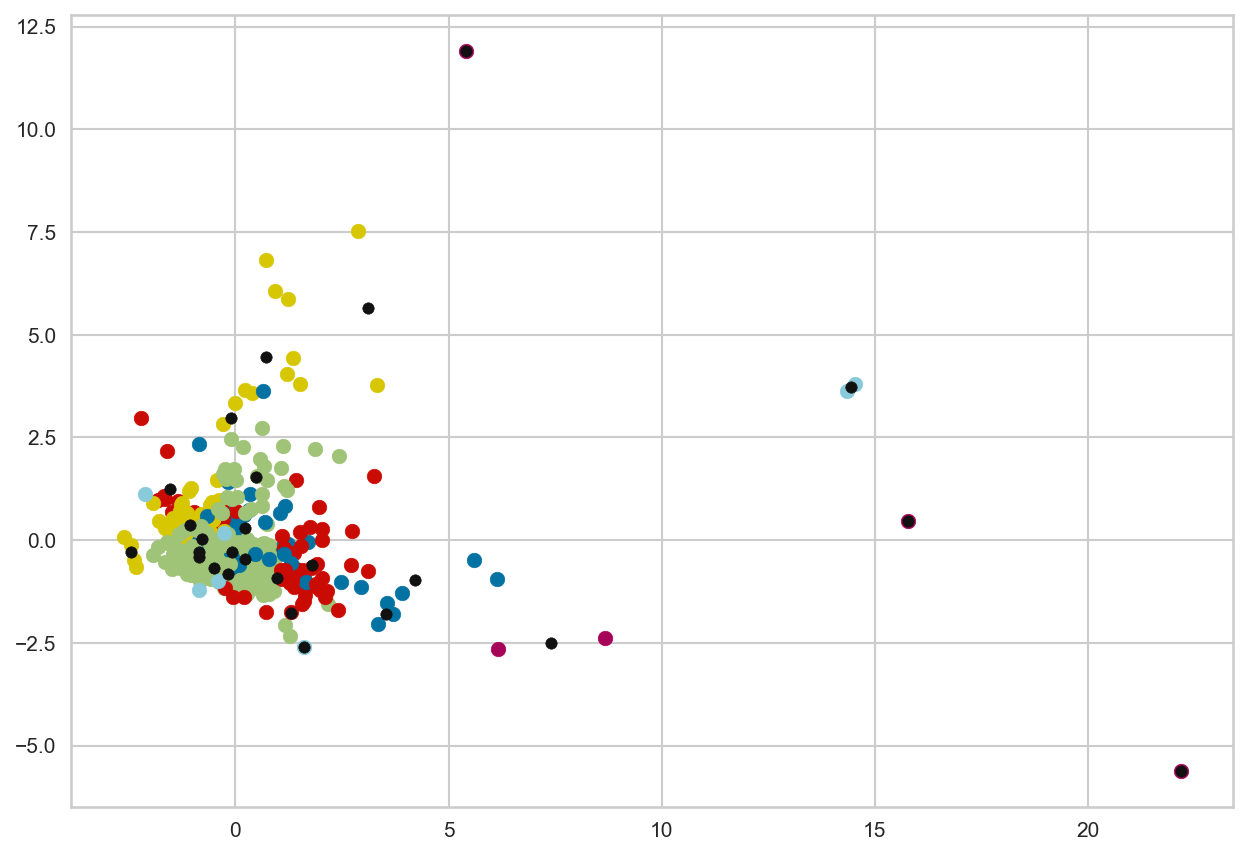

In [14]:
K = visualizer.elbow_value_
# implement model with K found above
kmeans = KMeans(n_clusters = K, init='k-means++', random_state=random_state)
label = kmeans.fit_predict(principalComponents)
u_labels = np.unique(label)

centroids = kmeans.cluster_centers_

for i in u_labels:
    plt.scatter(principalComponents[label == i , 0] , principalComponents[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 30, color = 'k')
plt.show()

In [15]:
PCA_components['Clusters'] = label
PCA_components

,0,1,2,3,4,5,6,7,Clusters
Symbol,,,,,,,,,
MMM,1.954490,0.799534,-0.161764,-0.028549,-0.284127,0.110315,0.000575,0.093749,14
AOS,-0.757980,-0.568019,0.180916,-0.190011,0.316272,-0.182417,0.029005,-0.017309,19
ABT,-0.546660,0.707972,0.480226,-0.250759,0.075067,-0.224046,0.261391,0.210648,2
ABBV,0.505176,1.558012,0.746134,0.175220,-0.462040,-0.370448,-0.117210,0.412528,25
ACN,0.733152,0.391715,-0.177340,-0.262515,0.303012,0.031617,0.061326,0.175145,7
...,...,...,...,...,...,...,...,...,...
XYL,-0.705662,-0.525644,0.084246,-0.268835,0.484540,-0.046812,0.103279,-0.006618,19
YUM,-0.267855,-0.093393,0.164874,2.178234,0.559155,-0.585620,-0.397079,-0.036793,1
ZBH,0.423553,-0.589568,-0.579177,-0.374844,0.341861,-0.282153,-0.694214,0.047125,7


In [29]:
cluster_pairs = pd.DataFrame()
cluster_pairs = pd.concat(i for cluster_pairs, i in PCA_components.groupby(by=PCA_components['Clusters']) if len(i)>1)
cluster_pairs
cluster_pairs.loc[cluster_pairs['Clusters'] == 12]


,0,1,2,3,4,5,6,7,Clusters
Symbol,,,,,,,,,
EQIX,3.567216,-1.537188,0.417316,0.762678,-1.756678,-0.462322,1.498966,-0.689964,12
ISRG,3.357243,-2.047655,1.677383,0.760340,-1.460505,-1.040590,-0.045428,-0.379179,12
REGN,3.692566,-1.788967,0.145754,0.154192,-0.593889,-0.776628,0.412413,-0.519749,12


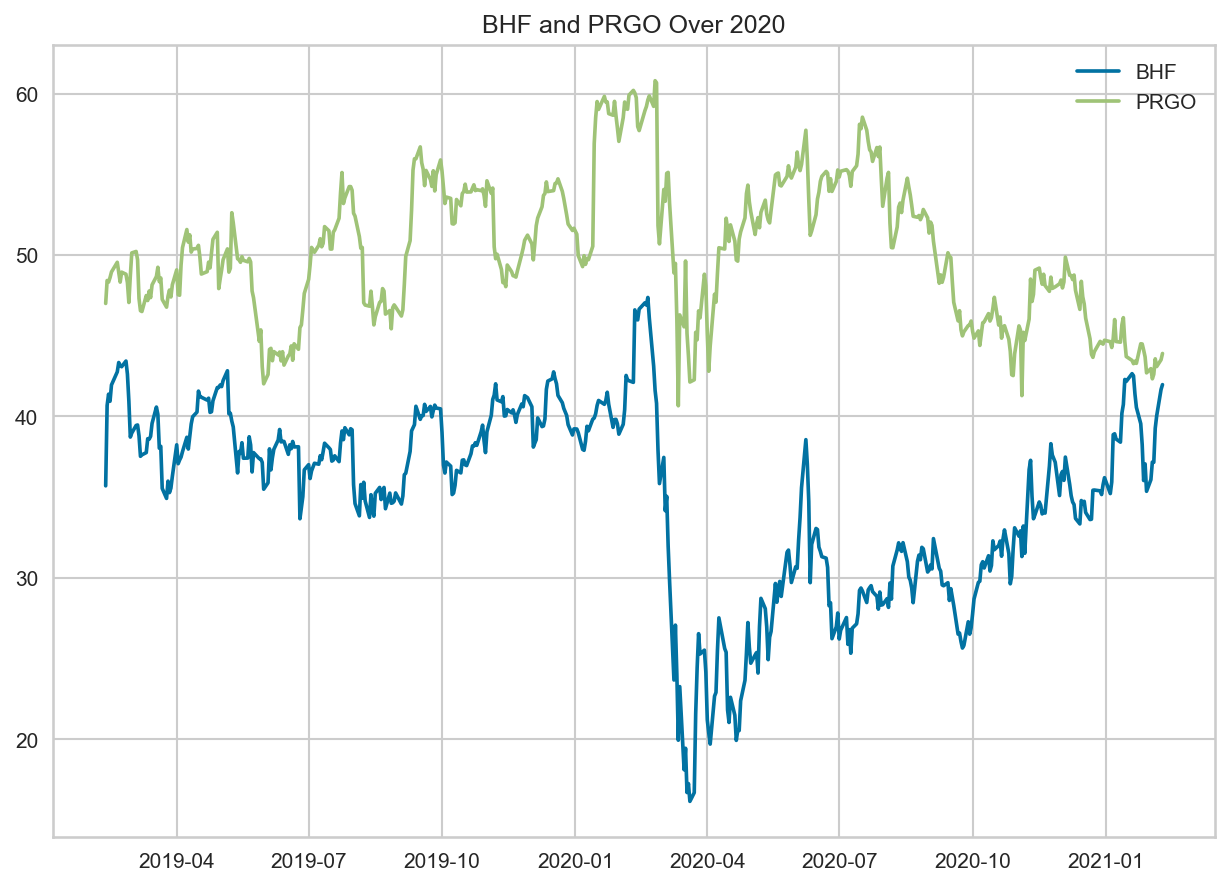

In [13]:
# pull the stock info from yahoo
start = '2019-02-09'
end = '2021-02-09'
name_1 = "BHF"
name_2 = "PRGO"
s1 = pdr.get_data_yahoo(name_1, start, end)
s2 = pdr.get_data_yahoo(name_2, start, end)

plt.plot(s1['Close'],label=name_1)
plt.plot(s2['Close'],label=name_2)
plt.title(name_1 + ' and ' + name_2 + ' Over 2020')
plt.legend(loc=0)
plt.show()

In [15]:
stocks = pd.DataFrame()
stocks[name_1] = s1['Close']
stocks[name_2] = s2['Close']

In [16]:
# create spread and perform ADF test
stocks['spread'] = np.log(stocks[name_1]) - np.log(stocks[name_2])
adf=adfuller(stocks['spread'])
adf

(-2.2413177462250555,
 0.19159256526112634,
 2,
 501,
 {'1%': -3.443470002903981,
  '5%': -2.867326248740681,
  '10%': -2.569851849873108},
 -1797.3728741391506)

In [17]:
# find adf significance 
# note: this is without hedge ratio implemented

if adf[0] < adf[4]['1%']:
    print('Spread is Cointegrated at 1% Significance Level')
elif adf[0] < adf[4]['5%']:
    print('Spread is Cointegrated at 5% Significance Level')
elif adf[0] < adf[4]['10%']:
    print('Spread is Cointegrated at 10% Significance Level')
else:
    print('Spread is not Cointegrated')

Spread is not Cointegrated
